In [ ]:
!pip install -q kaggle

#Get kaggle.json from kaggle profile account under api section and upload it
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list
!kaggle datasets download 'msambare/fer2013'

In [ ]:
!unzip /content/fer2013.zip

In [ ]:
import tensorflow as tf

img_width = 96
img_height = 96

batch_size = 64

In [ ]:
train_dir = "/content/train"
test_dir = "/content/test"

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 28709 files belonging to 7 classes.
Using 5741 files for validation.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size,
)

Found 7178 files belonging to 7 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 96, 96, 3)
(64,)


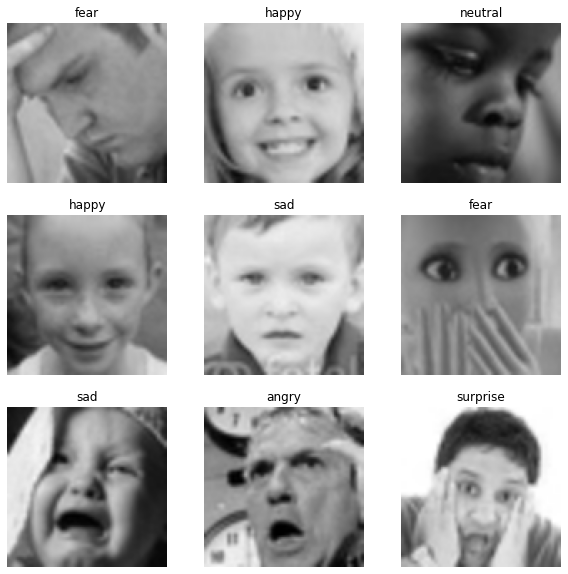

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
import os
import pandas as pd

classes = 7

#make a count of the different classes
def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + '/' + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       disgust  fear   sad  surprise  neutral  angry  happy
train      436  4097  4830      3171     4965   3995   7215
      disgust  fear   sad  surprise  neutral  angry  happy
test      111  1024  1247       831     1233    958   1774


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
from tensorflow.keras.applications import MobileNetV2
import tensorflow.keras.layers as tfl
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
global_layer = tfl.GlobalAveragePooling2D()

In [ ]:
IMG_SIZE = (96,96)
def get_model(image_shape=IMG_SIZE):
    
    
    input_shape = IMG_SIZE + (3,)
    
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    
    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape) 

    x = preprocess_input(inputs)
    
    x = base_model(x,training=False) 
    
    x = global_layer(x)
    x = tfl.Dropout(0.2)(x)

    outputs = tfl.Dense(7,activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    return model

In [ ]:
model = get_model()
model.summary()

9420800/9406464 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 96, 96, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 96, 96, 3)        0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1280)             0        

In [ ]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
!mkdir /content/Checkpoint

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=1e-6)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/Checkpoint/{epoch:02d}-{val_loss:.2f}-{accuracy:.2f}.hdf5',
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
history = model.fit(
    train_ds, epochs=20, callbacks=[model_checkpoint_callback, reduce_lr], validation_data=val_ds
)

Epoch 1/20
359/359 [==============================] - 41s 56ms/step - loss: 1.7236 - accuracy: 0.3581 - val_loss: 1.4613 - val_accuracy: 0.4443 - lr: 0.0010
Epoch 2/20
359/359 [==============================] - 18s 51ms/step - loss: 1.4912 - accuracy: 0.4345 - val_loss: 1.4160 - val_accuracy: 0.4628 - lr: 0.0010
Epoch 3/20
359/359 [==============================] - 18s 51ms/step - loss: 1.4306 - accuracy: 0.4596 - val_loss: 1.4045 - val_accuracy: 0.4632 - lr: 0.0010
Epoch 4/20
359/359 [==============================] - 18s 51ms/step - loss: 1.4016 - accuracy: 0.4705 - val_loss: 1.3895 - val_accuracy: 0.4672 - lr: 0.0010
Epoch 5/20
359/359 [==============================] - 18s 50ms/step - loss: 1.3918 - accuracy: 0.4724 - val_loss: 1.4001 - val_accuracy: 0.4731 - lr: 0.0010
Epoch 6/20
359/359 [==============================] - 18s 51ms/step - loss: 1.3839 - accuracy: 0.4743 - val_loss: 1.3893 - val_accuracy: 0.4729 - lr: 0.0010
Epoch 7/20
359/359 [==============================] - 18s 

In [ ]:
initial_epochs = 20

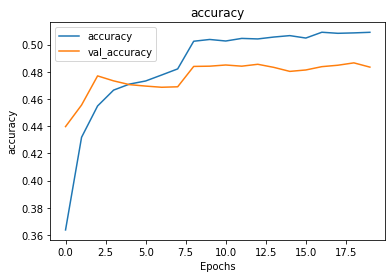

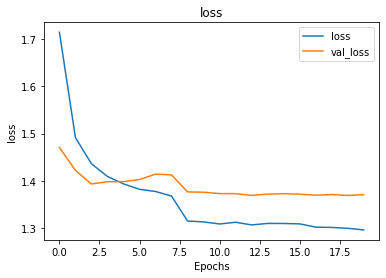

In [ ]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.title(string)
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
base_model = model.layers[3]
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

loss_function='sparse_categorical_crossentropy'

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1*base_learning_rate)

metrics=['accuracy']

model.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)


Number of layers in the base model:  154


In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds,
                         callbacks=[model_checkpoint_callback, reduce_lr])

Epoch 20/30
359/359 [==============================] - 32s 76ms/step - loss: 1.3538 - accuracy: 0.4824 - val_loss: 1.2386 - val_accuracy: 0.5290 - lr: 1.0000e-04
Epoch 21/30
359/359 [==============================] - 26s 73ms/step - loss: 1.1426 - accuracy: 0.5670 - val_loss: 1.1678 - val_accuracy: 0.5595 - lr: 1.0000e-04
Epoch 22/30
359/359 [==============================] - 27s 75ms/step - loss: 1.0369 - accuracy: 0.6098 - val_loss: 1.0958 - val_accuracy: 0.5867 - lr: 1.0000e-04
Epoch 23/30
359/359 [==============================] - 27s 74ms/step - loss: 0.9357 - accuracy: 0.6486 - val_loss: 1.1014 - val_accuracy: 0.5893 - lr: 1.0000e-04
Epoch 24/30
359/359 [==============================] - 26s 72ms/step - loss: 0.8397 - accuracy: 0.6870 - val_loss: 1.1259 - val_accuracy: 0.5975 - lr: 1.0000e-04
Epoch 25/30
359/359 [==============================] - 26s 72ms/step - loss: 0.7352 - accuracy: 0.7275 - val_loss: 1.1320 - val_accuracy: 0.6081 - lr: 1.0000e-04
Epoch 26/30
359/359 [=======

In [ ]:
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
model.evaluate(test_ds)

113/113 [==============================] - 5s 45ms/step - loss: 1.4004 - accuracy: 0.6399


[1.4004087448120117, 0.6398718357086182]

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.figure(figsize=(10,10))



    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)

    plt.colorbar()



    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)



    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        cm = np.around(cm, decimals=2)

        cm[np.isnan(cm)] = 0.0

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')

In [ ]:
labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Y_pred = model.predict(test_ds)

y_pred = np.argmax(Y_pred, axis=1)
y_pred

array([5, 5, 3, ..., 2, 2, 3])

In [ ]:
y_pred.shape

(7178,)

In [ ]:
y_pred = [] 
y_true = []  

for image_batch, label_batch in test_ds:

   y_true.append(label_batch)

   preds = model.predict(image_batch)

   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [ ]:
len(y_true)

113

Confusion matrix, without normalization


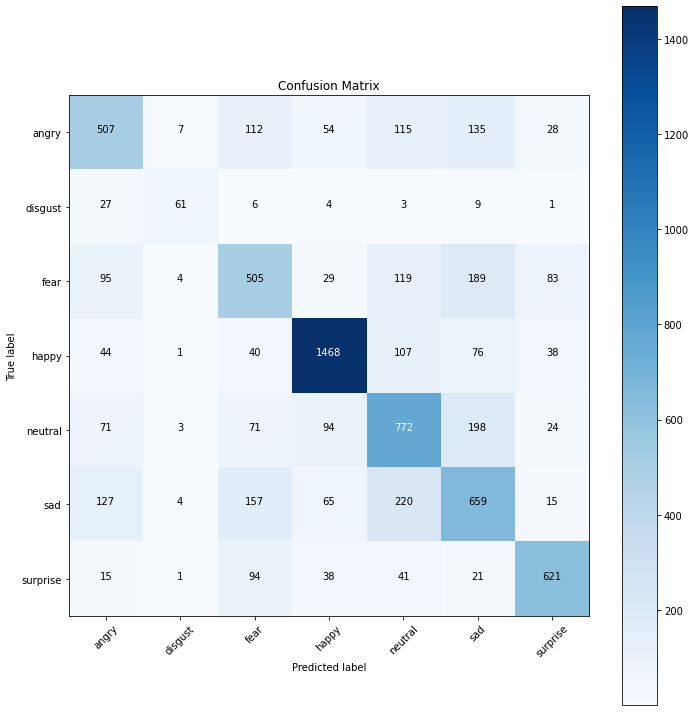

In [ ]:
cm = confusion_matrix(correct_labels, predicted_labels)

plot_confusion_matrix(cm, labels, normalize=False, title='Confusion Matrix')


Normalized confusion matrix


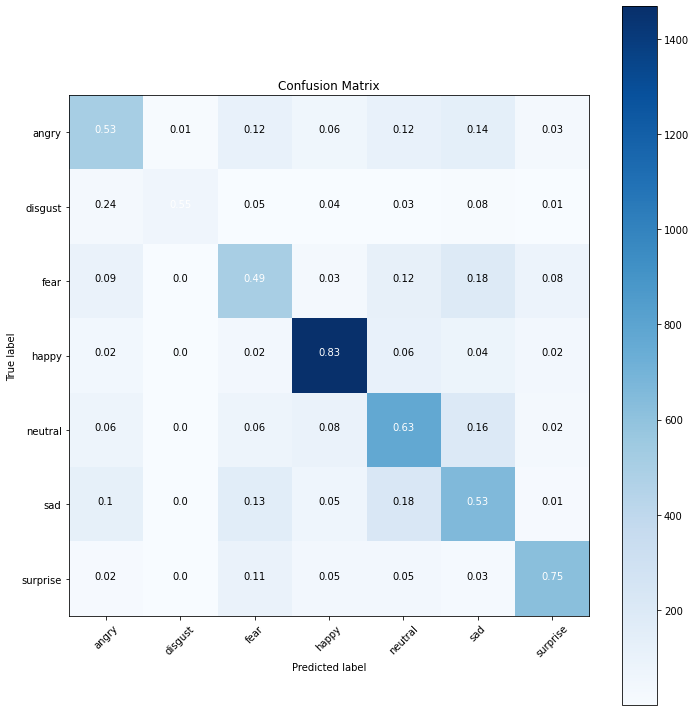

In [ ]:
cm1 = confusion_matrix(correct_labels, predicted_labels)

plot_confusion_matrix(cm1, labels, normalize=True, title='Confusion Matrix')

In [ ]:
def prediction(image_path):
    img = tf.keras.utils.load_img(
          image_path, target_size=(img_height, img_width))

    img = tf.keras.utils.img_to_array(img)
        
    plt.title('Image')
    plt.axis('off')
    plt.imshow((img/255.0).squeeze())
        
    predict = model.predict(img[np.newaxis , ...])
    predicted_class = labels[np.argmax(predict[0] , axis = -1)]
        
    print('Prediction Value: ' , np.max(predict[0] , axis = -1))
    print("Classified:",predicted_class)

Prediction Value:  0.9999726
Classified: happy


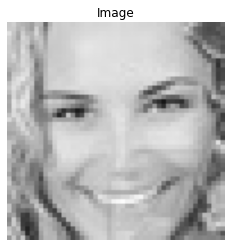

In [ ]:
prediction('/content/test/happy/PrivateTest_10077120.jpg')